In [1]:
import numpy as np
import matplotlib.pyplot as plt
from vocalseg.examples import mouse
from vocalseg.utils import butter_bandpass_filter, spectrogram, int16tofloat32, plot_spec

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from scipy.io import loadmat
from pathlib2 import Path

In [4]:
from vocalseg.utils import butter_bandpass_filter, spectrogram, int16tofloat32, plot_spec
from vocalseg.dynamic_thresholding import dynamic_threshold_segmentation

In [5]:
### parameters
n_fft=4096
hop_length_ms=1
win_length_ms=4
ref_level_db=20
pre=0.97
min_level_db=-70
silence_threshold = 0.01
min_silence_for_spec=0.1
max_vocal_for_spec=1.0,
min_syllable_length_s = 0.01
spectral_range = [50000, 100000]

In [6]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [7]:
MATFILE = Path('/mnt/cube/Datasets/mouse_usv/FromGregg/sample_Bl6_breathing_data.mat')

In [8]:
voc_df = loadmat(MATFILE)
voc_df = pd.DataFrame(voc_df['breathing'][0])
voc_df['length_s'] = [np.max(row.time) for idx, row in voc_df.iterrows()]
voc_df

,mouse,genotype,age,time,pressure,audio,audioTime,fs,audioFS,length_s
0,[829],[C57Bl/6J],[P76],"[[1e-04, 0.0002, 0.0003, 0.0004, 0.0005, 0.000...","[[-0.062698364, -0.06253052, -0.062194824, -0....","[[0.0017700195], [0.0007324219], [-0.002227783...","[[-0.0017913372, -0.0017873376, -0.001783338, ...",[[10000]],[[250000]],204.633896
1,[832],[C57Bl/6J],[P76],"[[1e-04, 0.0002, 0.0003, 0.0004, 0.0005, 0.000...","[[-0.016738892, -0.016723633, -0.016830444, -0...","[[-0.00021362305], [0.0005493164], [0.00045776...","[[-0.0013908836, -0.001386884, -0.0013828843, ...",[[10000]],[[250000]],104.798103
2,[832],[C57Bl/6J],[P76],"[[1e-04, 0.0002, 0.0003, 0.0004, 0.0005, 0.000...","[[-0.01876831, -0.018966675, -0.019165039, -0....","[[0.00024414062], [-0.00012207031], [6.1035156...","[[-0.012664578, -0.012660579, -0.012656579, -0...",[[10000]],[[250000]],141.035095


In [9]:
row = voc_df.iloc[1]

In [10]:
rate = row.audioFS[0][0]
rate

250000

In [11]:
data = row.audio.flatten()
print(len(data)/rate)
#data = data[:int(20*rate)]

104.798096


In [12]:
data = butter_bandpass_filter(data, 500, 120000, rate)

In [13]:
len(data)

26199524

In [16]:
data = data[:1000000]

In [17]:
figsize = (20,3)

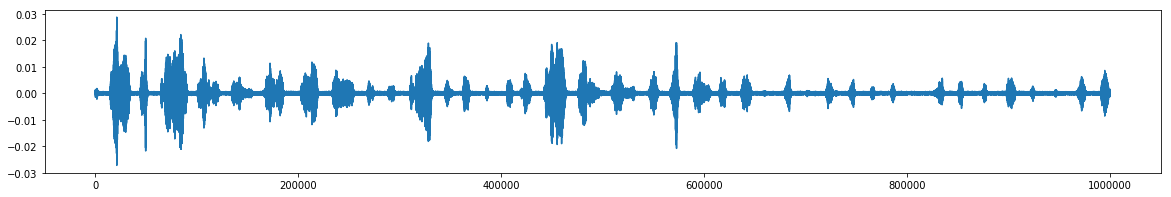

In [18]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(data)

In [27]:
### parameters
n_fft=4096 # FFT window size
hop_length_ms=1
win_length_ms=4
ref_level_db=20
pre=0.97
min_level_db=-80
silence_threshold = 0.05
min_silence_for_spec=0.015
max_vocal_for_spec=1.0,
min_syllable_length_s = 0.01
spectral_range = [40000, 120000]
mask_thresh_std = 1.0
neighborhood_thresh=0.5
max_element_len_ms=2000
neighborhood_time_ms=5
neighborhood_freq_hz=2000
temporal_neighbor_merge_distance_ms= 0
overlapping_element_merge_thresh= 0.5
min_element_size_ms_hz = [5, 1000]

In [28]:
spec = spectrogram(
    data,
    rate,
    n_fft=n_fft,
    hop_length_ms=hop_length_ms,
    win_length_ms=win_length_ms,
    ref_level_db=ref_level_db,
    pre=pre,
    min_level_db=min_level_db,
)
np.shape(spec)

(2049, 4001)

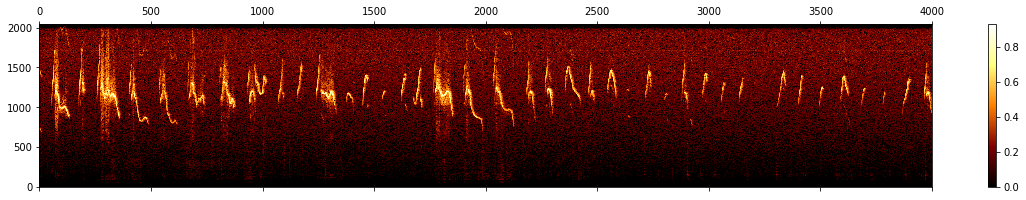

In [29]:
fig, ax = plt.subplots(figsize=figsize)
plot_spec(spec, fig, ax);

In [30]:
from vocalseg.dynamic_thresholding import dynamic_threshold_segmentation


In [31]:
results = dynamic_threshold_segmentation(
    data,
    rate,
    n_fft=n_fft,
    hop_length_ms=hop_length_ms,
    win_length_ms=win_length_ms,
    ref_level_db=ref_level_db,
    pre=pre,
    min_level_db=min_level_db,
    silence_threshold = silence_threshold,
    verbose=True,
    spectral_range = spectral_range,
    min_syllable_length_s = min_syllable_length_s
    
)

longest silence 0.04800000000000004
longest vocalization 0.11199999999999999
Current min_level_db: -80
longest silence 0.04800000000000004
longest vocalization 0.11199999999999999
Current min_level_db: -75
longest silence 0.07399999999999984
longest vocalization 0.10999999999999999
Current min_level_db: -70
longest silence 0.12199999999999989
longest vocalization 0.10899999999999999


In [32]:
figsize = (100, 4)

In [33]:
from vocalseg.dynamic_thresholding import plot_segmented_spec, plot_segmentations

In [34]:
from matplotlib import gridspec

In [35]:
from matplotlib.collections import PatchCollection

In [36]:
from matplotlib.patches import Rectangle

In [37]:
def plot_segmentations(
    spec, vocal_envelope, onsets, offsets, hop_length_ms, rate, figsize=(30, 5)
):
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3])
    gs.update(hspace=0.0)  # set the spacing between axes.
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    plot_spec(spec, fig, ax1, rate=rate, hop_len_ms=hop_length_ms, show_cbar=False)
    ax0.plot(vocal_envelope, color="k")
    ax0.set_xlim([0, len(vocal_envelope)])
    ax1.xaxis.tick_bottom()
    ylmin, ylmax = ax1.get_ylim()
    ysize = (ylmax - ylmin) * 0.1
    ymin = ylmax - ysize

    patches = []
    for onset, offset in zip(onsets, offsets):
        ax1.axvline(onset, color="#FFFFFF", ls="dashed", lw=0.75)
        ax1.axvline(offset, color="#FFFFFF", ls="dashed", lw=0.75)
        patches.append(Rectangle(xy=(onset, ymin), width=offset - onset, height=ysize))

    collection = PatchCollection(patches, color="white", alpha=0.5)
    ax1.add_collection(collection)
    ax0.axis("off")

In [38]:
figsize = (20,4)

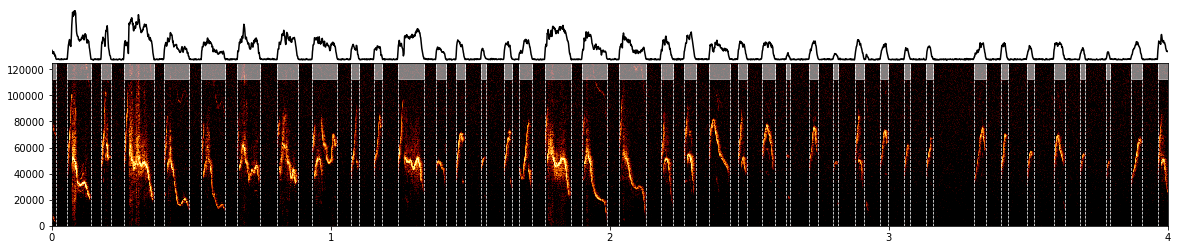

In [39]:
plot_segmentations(
    results["spec"],
    vocal_envelope=results["vocal_envelope"],
    onsets=results["onsets"],
    offsets=results["offsets"],
    rate=rate,
    hop_length_ms=hop_length_ms,
    figsize=figsize,
)

In [40]:
from vocalseg.dynamic_thresholding import LinearSegmentedColormap

In [41]:
import seaborn as sns

In [42]:
def plot_segmented_spec(
    spec, onsets, offsets, hop_length_ms, background="black", figsize=(30, 5)
):
    """ plot spectrogram with colormap labels
    """
    pal = np.random.permutation(sns.color_palette("hsv", n_colors=len(onsets)))
    fft_rate = 1000 / hop_length_ms
    new_spec = np.zeros(list(np.shape(spec)) + [4])
    for onset, offset, pi in zip(onsets, offsets, pal):
        if background == "black":
            cdict = {
                "red": [(0, pi[0], pi[0]), (1, 1, 1)],
                "green": [(0, pi[1], pi[1]), (1, 1, 1)],
                "blue": [(0, pi[2], pi[2]), (1, 1, 1)],
                "alpha": [(0, 0, 0), (0.25, 0.5, 0.5), (1, 1, 1)],
            }
        else:
            cdict = {
                "red": [(0, pi[0], pi[0]), (1, 0, 0)],
                "green": [(0, pi[1], pi[1]), (1, 0, 0)],
                "blue": [(0, pi[2], pi[2]), (1, 0, 0)],
                "alpha": [(0, 0, 0), (1, 1, 1)],
            }

        cmap = LinearSegmentedColormap("CustomMap", cdict)

        start_frame = int(onset * fft_rate)
        stop_frame = int(offset * fft_rate)
        new_spec[:, start_frame:stop_frame, :] = cmap(spec[:, start_frame:stop_frame])

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_facecolor(background)
    ax.imshow(new_spec, interpolation=None, aspect="auto", origin="lower")

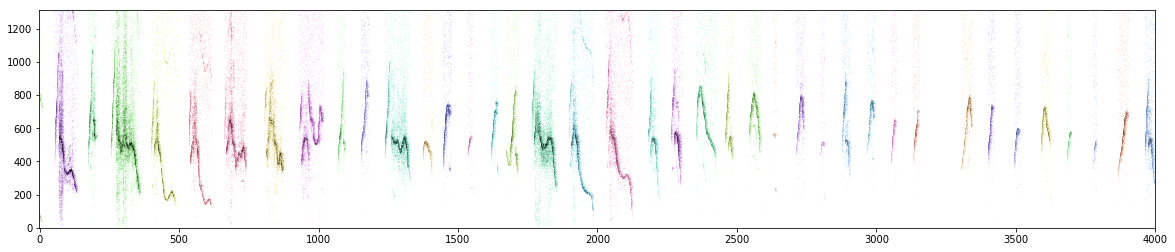

In [43]:
plot_segmented_spec(
    spec=results["spec"].copy(),
    onsets=results["onsets"].copy(),
    offsets=results["offsets"].copy(),
    hop_length_ms = hop_length_ms,
    background="white",
    figsize=figsize
)

In [44]:
def plot_spec(
    spec,
    fig=None,
    ax=None,
    rate=None,
    hop_len_ms=None,
    cmap=plt.cm.afmhot,
    show_cbar=True,
    figsize=(20, 6),
):
    """plot spectrogram
    
    [description]
    
    Arguments:
        spec {[type]} -- [description]
        fig {[type]} -- [description]
        ax {[type]} -- [description]
    
    Keyword Arguments:
        cmap {[type]} -- [description] (default: {plt.cm.afmhot})
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    extent = [0, np.shape(spec)[1], 0, np.shape(spec)[0]]
    if rate is not None:
        extent[3] = rate / 2
    if hop_len_ms is not None:
        extent[1] = (np.shape(spec)[1] * hop_len_ms) / 1000

    spec_ax = ax.imshow(
        spec,
        interpolation=None,
        aspect="auto",
        origin="lower",
        extent=extent,
    )
    if show_cbar:
        cbar = fig.colorbar(spec_ax, ax=ax)
        return spec_ax, cbar
    else:
        return spec_ax

In [45]:
def plot_segmented_spec(
    spec, onsets, offsets, hop_length_ms, vocal_envelope, rate, background="black", figsize=(30, 5)
):
    """ plot spectrogram with colormap labels
    """
    pal = np.random.permutation(sns.color_palette("hsv", n_colors=len(onsets)))
    fft_rate = 1000 / hop_length_ms
    new_spec = np.zeros(list(np.shape(spec)) + [4])
    for onset, offset, pi in zip(onsets, offsets, pal):
        if background == "black":
            cdict = {
                "red": [(0, pi[0], pi[0]), (1, 1, 1)],
                "green": [(0, pi[1], pi[1]), (1, 1, 1)],
                "blue": [(0, pi[2], pi[2]), (1, 1, 1)],
                "alpha": [(0, 0, 0), (0.25, 0.5, 0.5), (1, 1, 1)],
            }
        else:
            cdict = {
                "red": [(0, pi[0], pi[0]), (1, 0, 0)],
                "green": [(0, pi[1], pi[1]), (1, 0, 0)],
                "blue": [(0, pi[2], pi[2]), (1, 0, 0)],
                "alpha": [(0, 0, 0), (1, 1, 1)],
            }

        cmap = LinearSegmentedColormap("CustomMap", cdict)

        start_frame = int(onset * fft_rate)
        stop_frame = int(offset * fft_rate)
        new_spec[:, start_frame:stop_frame, :] = cmap(spec[:, start_frame:stop_frame])

    
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3])
    gs.update(hspace=0.0)  # set the spacing between axes.
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax1.set_facecolor(background)
    #ax1.imshow(new_spec, interpolation=None, aspect="auto", origin="lower")
    #ax1.imshow(new_spec, interpolation=None, aspect="auto", origin="lower")
    plot_spec(new_spec, fig, ax1, rate=rate, hop_len_ms=hop_length_ms, show_cbar=False)
    ax0.plot(vocal_envelope, color="k")
    ax0.set_xlim([0, len(vocal_envelope)])
    ax1.xaxis.tick_bottom()
    ylmin, ylmax = ax1.get_ylim()
    ysize = (ylmax - ylmin) * 0.1
    ymin = ylmax - ysize
    patchcol = "white" if background == "black" else "black"
    patches = []
    for onset, offset in zip(onsets, offsets):
    #    ax1.axvline(onset, color="#FFFFFF", ls="dashed", lw=0.75)
    #    ax1.axvline(offset, color="#FFFFFF", ls="dashed", lw=0.75)
        patches.append(Rectangle(xy=(onset, ymin), width=offset - onset, height=ysize))

    collection = PatchCollection(patches, color=patchcol, alpha=0.5)
    ax1.add_collection(collection)
    ax0.axis("off")
    for i in ax1.spines.values():
        i.set_linewidth(4) 


In [46]:
plt.rcParams.update({'font.size': 16})

In [47]:
figsize = (30,4)

In [48]:
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

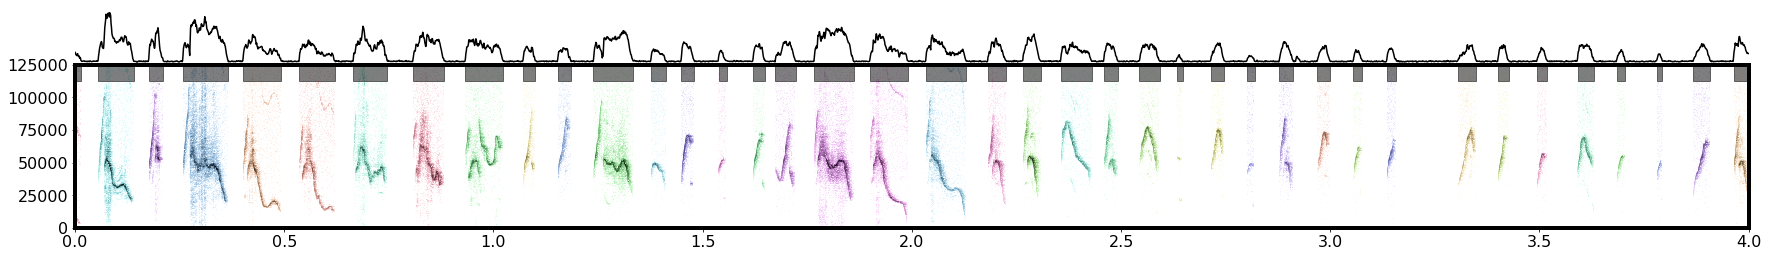

In [49]:
plot_segmented_spec(
    spec=results["spec"].copy(),
    onsets=results["onsets"].copy(),
    offsets=results["offsets"].copy(),
    hop_length_ms = hop_length_ms,
    background="white",
    figsize=figsize,
    vocal_envelope=results["vocal_envelope"],
    rate=rate,
)
save_fig(FIGURE_DIR / 'mouse_segmentation', dpi=300, save_jpg=True)


NameError: name 'FIGURE_DIR' is not defined

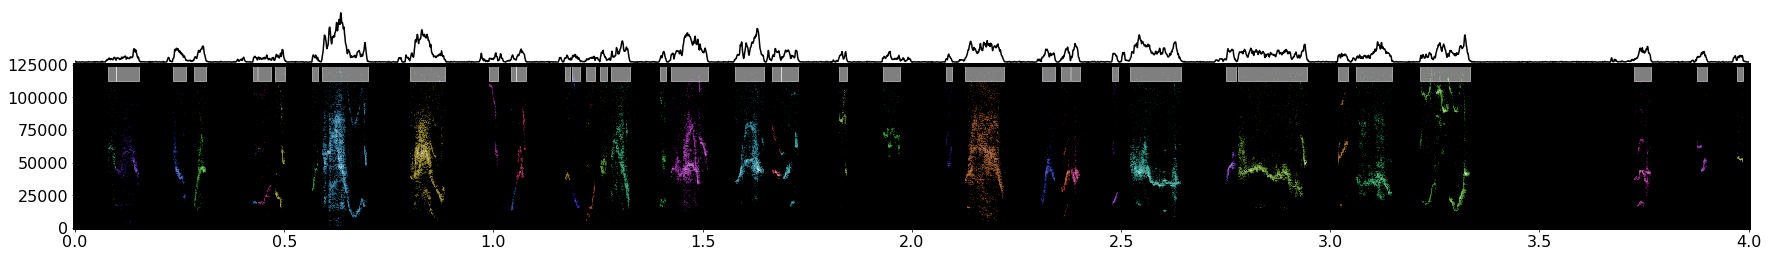

In [97]:
plot_segmented_spec(
    spec=results["spec"].copy(),
    onsets=results["onsets"].copy(),
    offsets=results["offsets"].copy(),
    hop_length_ms = hop_length_ms,
    background="black",
    figsize=figsize,
    vocal_envelope=results["vocal_envelope"],
    rate=rate,
)
save_fig(FIGURE_DIR / 'canary_segmentation', dpi=300, save_jpg=True)
